In [92]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms 
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm # provides a progess bar for loops

In [93]:
# to use Apple's Metal Performance Shaders (MPS) for GPU acceleration
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# CNN Architecture for MNIST

The MNIST dataset consists of grayscale images for handwritten digits (0-9), each of size 28x28 pixels.

* Input Channels: Since MNIST is grayscale we only have one channel
* Output Channels: This is the #filters used in a convolutional layer. Each filter detects different features from the input image.
More filters can capture more detailed features but require more computational resources and can lead to overfitting on small datasets like MNIST.
* Kernel Size: Size of the convolution window(filter). This affects teh amount of detail the filter can capture. Common choice is 3x3 or 5x5
* Stride: defiens how mcuh the filter moves across the image, Stride of 1 means filter moves one pixel at a time. Increasing stride reduces output spatial dimensions
* Padding: Used to add zeroes around the border of the input. This is helpful to control the spatial size of the output features map, allowing more control over how deep the network can be
* Activation function: ReLU is used

Pooling Layer:

* Kernel Size = 2: Sets area over which the maximum value will be taken as 2x2
* Stride = 2: The pooling operation is applied with a stride of 2, reduces the spatial dimensions of the feature maps by half. 
This reduction helps to make the model more robust to small variations and decreases the spatial size of the feature maps, significantly reducing the number of parameters.
* Pooling Type: Max Pooling outputs the maximum value from each part of the feature map covered by hte kernel.

Convolutional Layer 2:

* in_channels = 8: matches #output channels from previous convolutional layer
* out_channels=16: Increasing the number of filters from 8 to 16 allows the network to learn more complex features in the second layer.

Fully Connected Layer (fc1):
* Input Size: After two pooling operations each reduced the spatial dimensions by half, size fo each feature map is 28/2/2 = 7 pixels ( since MNIST images are 28x28). There are 16 such feature maps fron conv2

Forward Method:

* Input x passes through conv1, gets activated by ReLU, and is downsampled by pooling.
* The same sequence follows with conv2.
* The output of the final pooling layer is flattened into a vector before being passed to the fully connected layer (fc1), which produces the class scores.


In [94]:
class CNN(nn.Module):

    def __init__(self, in_channels = 1, num_classes = 10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 8, kernel_size = 3, stride = 1, padding = 1)

        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.conv2 = nn.Conv2d(
            in_channels = 8, out_channels = 16, kernel_size = 3, stride = 1, padding = 1
        )
        self.fc1 = nn.Linear(16*7*7, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        return x


In [95]:
# hyperparameters
in_channels = 1
num_classes = 10
learning_rate = 3e-4 # Kaparthy's constant
batch_size = 64 # number of samples seed each iteraction of the training phase
num_epochs = 5 # one epoch is one complete pass through the entire training dataset

In [96]:
train_dataset = datasets.MNIST(root = "dataset/", train = True, transform = transforms.ToTensor(), download = True)

In [97]:
first_image, first_label = train_dataset[0]
num_images = len(train_dataset)
num_images, first_image.shape, first_label # we havae 60000 images in the training dataset, each image is 1x28x28, and the first label is 5

(60000, torch.Size([1, 28, 28]), 5)

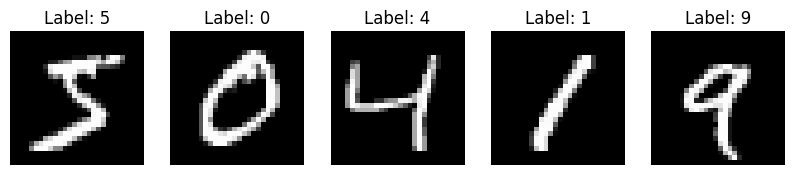

In [98]:
# plot the first few images
import matplotlib.pyplot as plt


def plot_images(images, labels, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(10, 2))
    for i, ax in enumerate(axes):
        ax.imshow(images[i].squeeze(), cmap='gray')  
        ax.title.set_text(f"Label: {labels[i]}")
        ax.axis('off')
    plt.show()

images = [train_dataset[i][0] for i in range(5)]
labels = [train_dataset[i][1] for i in range(5)]


plot_images(images, labels)

In [99]:
test_dataset = datasets.MNIST(
    root="dataset/", train=False, transform=transforms.ToTensor(), download=True
)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


In [100]:
len(test_dataset) # 10000 images in the test dataset

10000

In [101]:
model = CNN(in_channels = in_channels, num_classes = num_classes)

In [102]:
model.to(mps_device)
model = model.float()

In [103]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

In [104]:

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")


Layer: conv1.weight | Size: torch.Size([8, 1, 3, 3]) | Values: tensor([[[[ 0.2582, -0.1039, -0.0061],
          [ 0.0632,  0.0417,  0.1206],
          [ 0.0481,  0.2265, -0.2256]]],


        [[[-0.0825,  0.2954,  0.0185],
          [ 0.2326,  0.1430,  0.1482],
          [ 0.0360,  0.0352, -0.2137]]]], device='mps:0',
       grad_fn=<SliceBackward0>) 

Layer: conv1.bias | Size: torch.Size([8]) | Values: tensor([-0.0880, -0.2963], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: conv2.weight | Size: torch.Size([16, 8, 3, 3]) | Values: tensor([[[[-0.1017,  0.0784,  0.0520],
          [ 0.1167, -0.0512,  0.0099],
          [-0.0983, -0.0697, -0.1019]],

         [[-0.0072,  0.0090, -0.0425],
          [-0.0352,  0.0886, -0.1112],
          [ 0.0975, -0.1055,  0.0021]],

         [[-0.0078, -0.0332,  0.0251],
          [ 0.0927, -0.0889, -0.0641],
          [-0.0583,  0.1065, -0.0241]],

         [[ 0.0623, -0.0098, -0.0095],
          [ 0.0246,  0.0908,  0.0149],
          [-0.0953, -0.

In [105]:
for epoch in range(num_epochs):
    # 60,000 images, so 60k/64(batch size) = 938 batches
    for batch_id, (data,targets) in enumerate(tqdm(train_loader)):
        data = data.to(mps_device)
        targets = targets.to(mps_device)

        scores = model(data)
        loss = criterion(scores, targets)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

100%|██████████| 938/938 [00:03<00:00, 254.13it/s]


In [106]:
# can observe changes in the parameters
for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values: {param[:2]} \n")

Layer: conv1.weight | Size: torch.Size([8, 1, 3, 3]) | Values: tensor([[[[ 0.4197,  0.0740,  0.1440],
          [ 0.3401,  0.3800,  0.4005],
          [ 0.3157,  0.5337, -0.0148]]],


        [[[ 0.1140,  0.5839,  0.2735],
          [ 0.5183,  0.4729,  0.4095],
          [ 0.2323,  0.2221, -0.1329]]]], device='mps:0',
       grad_fn=<SliceBackward0>) 

Layer: conv1.bias | Size: torch.Size([8]) | Values: tensor([ 0.0007, -0.0154], device='mps:0', grad_fn=<SliceBackward0>) 

Layer: conv2.weight | Size: torch.Size([16, 8, 3, 3]) | Values: tensor([[[[-0.0647,  0.1799,  0.1262],
          [ 0.1834,  0.0808,  0.1827],
          [-0.3369, -0.2343, -0.0357]],

         [[-0.0103,  0.0834, -0.0035],
          [ 0.0656,  0.2451,  0.0418],
          [-0.0945, -0.2360,  0.1129]],

         [[-0.0078, -0.0332,  0.0251],
          [ 0.0927, -0.0889, -0.0696],
          [-0.0583,  0.1065, -0.0289]],

         [[ 0.0632,  0.0656,  0.0339],
          [ 0.1469,  0.3005,  0.2389],
          [-0.1763, -0.

# Function: check_accuracy

This function is designed to evaluate the performance of a PyTorch model on a given dataset using a DataLoader. It performs the following operations:

 1. **Model Evaluation Mode**
   - `model.eval()`: Sets the model to evaluation mode. This is crucial as it disables layers like dropout and batch normalization that behave differently during training and inference.

 2. **No Gradient Calculation**
   - `with torch.no_grad()`: Ensures that the code within this block does not compute gradients, which reduces memory consumption and speeds up computations, making it ideal for inference.

 3. **Data Processing Loop**
   - The function iterates over the `loader`, which batches the dataset for evaluation.
   - `input_images.to(device)` and `labels.to(device)`: Moves the images and labels to the specified `device` (like CPU or GPU), ensuring that the computations are performed where the model resides.

 4. **Prediction and Collection**
   - `outputs = model(input_images)`: Passes batched images through the model to get the output logits.
   - `_, predictions = torch.max(outputs, 1)`: Computes the predicted class by finding the index with the maximum logit value, which corresponds to the most likely class.
   - Accumulates all predictions and actual labels to compute overall metrics.

 5. **Track Misclassifications**
   - Identifies mismatches between predictions and actual labels (`predictions != labels`).
   - Stores up to `num_mismatches` misclassified images along with their predicted and true labels for later review.

 6. **Switch Back to Training Mode**
   - `model.train()`: Resets the model to training mode after evaluation is done.

 7. **Compute Metrics**
   - Utilizes `sklearn.metrics` to calculate key metrics:
       - `accuracy = accuracy_score(all_labels, all_predictions)`: Computes the overall accuracy of the model on the dataset.
       - `conf_matrix = confusion_matrix(all_labels, all_predictions)`: Generates a confusion matrix to see the model's performance across different classes.
       - `cls_report = classification_report(all_labels, all_predictions)`: Provides a detailed classification report which includes precision, recall, f1-score, and support for each class.

 8. **Output**
   - Prints the computed metrics.
   - Returns the metrics and the list of misclassified samples for further analysis.


In [107]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np

def check_accuracy(loader, model, device, num_mismatches=5):
    model.eval()
    all_predictions = []
    all_labels = []
    mismatches = []

    with torch.no_grad():
        for input_images, labels in loader:
            input_images = input_images.to(device)
            labels = labels.to(device)

            outputs = model(input_images)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            wrong_preds = predictions != labels
            if len(mismatches) < num_mismatches:
                for image, true_label, pred_label in zip(input_images[wrong_preds], labels[wrong_preds], predictions[wrong_preds]):
                    if len(mismatches) < num_mismatches:
                        mismatches.append((image.cpu(), true_label.cpu().item(), pred_label.cpu().item()))

    model.train()

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_predictions)
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    cls_report = classification_report(all_labels, all_predictions)

    print(f"Accuracy: {accuracy}")
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(cls_report)

    return accuracy, conf_matrix, cls_report, mismatches



In [108]:

accuracy_train, confusion_mtx_train, class_report_train, mismatches_train = check_accuracy(train_loader, model, mps_device, num_mismatches = 5)

Accuracy: 0.97035
Confusion Matrix:
[[5830    2   16    4    1    8   22    9   19   12]
 [   1 6646   33   11   15    0    2    7   26    1]
 [   4   32 5784   32   24    1    4   33   31   13]
 [   8   14   47 5939    0   27    2   18   39   37]
 [   3   19   10    1 5672    0   12   13   12  100]
 [   5    5    6   58    4 5243   39    5   31   25]
 [  14   16    3    0   12   25 5829    0   19    0]
 [   6   11   51   37   19    1    0 6014   12  114]
 [  18   60   37   67   12   28   29   10 5527   63]
 [  10   20    1   47   24   18    2   62   28 5737]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5923
           1       0.97      0.99      0.98      6742
           2       0.97      0.97      0.97      5958
           3       0.96      0.97      0.96      6131
           4       0.98      0.97      0.98      5842
           5       0.98      0.97      0.97      5421
           6       0.98      0.

In [109]:

accuracy, confusion_mtx, class_report, mismatches = check_accuracy(test_loader, model, mps_device, num_mismatches = 50)


Accuracy: 0.9716
Confusion Matrix:
[[ 972    0    1    0    0    1    1    3    2    0]
 [   0 1124    4    1    0    0    2    0    4    0]
 [   6    6  993    4    2    0    1    9    9    2]
 [   1    1    3  992    0    1    0    4    5    3]
 [   1    1    2    0  954    0    4    2    2   16]
 [   3    1    0   12    0  860    5    2    7    2]
 [   5    3    0    1    5    5  935    0    4    0]
 [   1    1   16    4    1    0    0  987    2   16]
 [   6    2    6   12    2    2    1    5  930    8]
 [   7    6    1    7    3    5    0   10    1  969]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.96      0.97       892
           6       0.99      0.9

In [110]:
print(f"Overall Accuracy: {100*accuracy}%\n")

Overall Accuracy: 97.16%



In [111]:
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.97      0.96      0.97      1032
           3       0.96      0.98      0.97      1010
           4       0.99      0.97      0.98       982
           5       0.98      0.96      0.97       892
           6       0.99      0.98      0.98       958
           7       0.97      0.96      0.96      1028
           8       0.96      0.95      0.96       974
           9       0.95      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



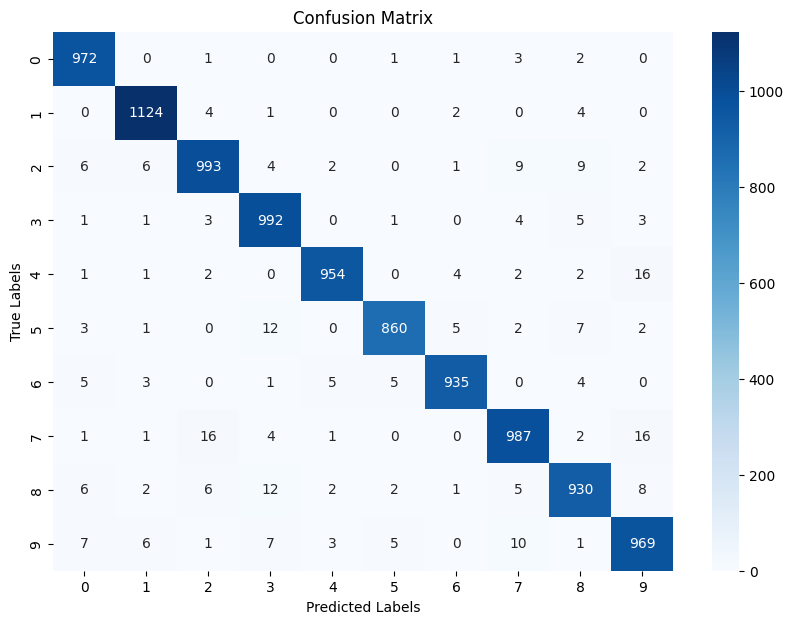

In [112]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


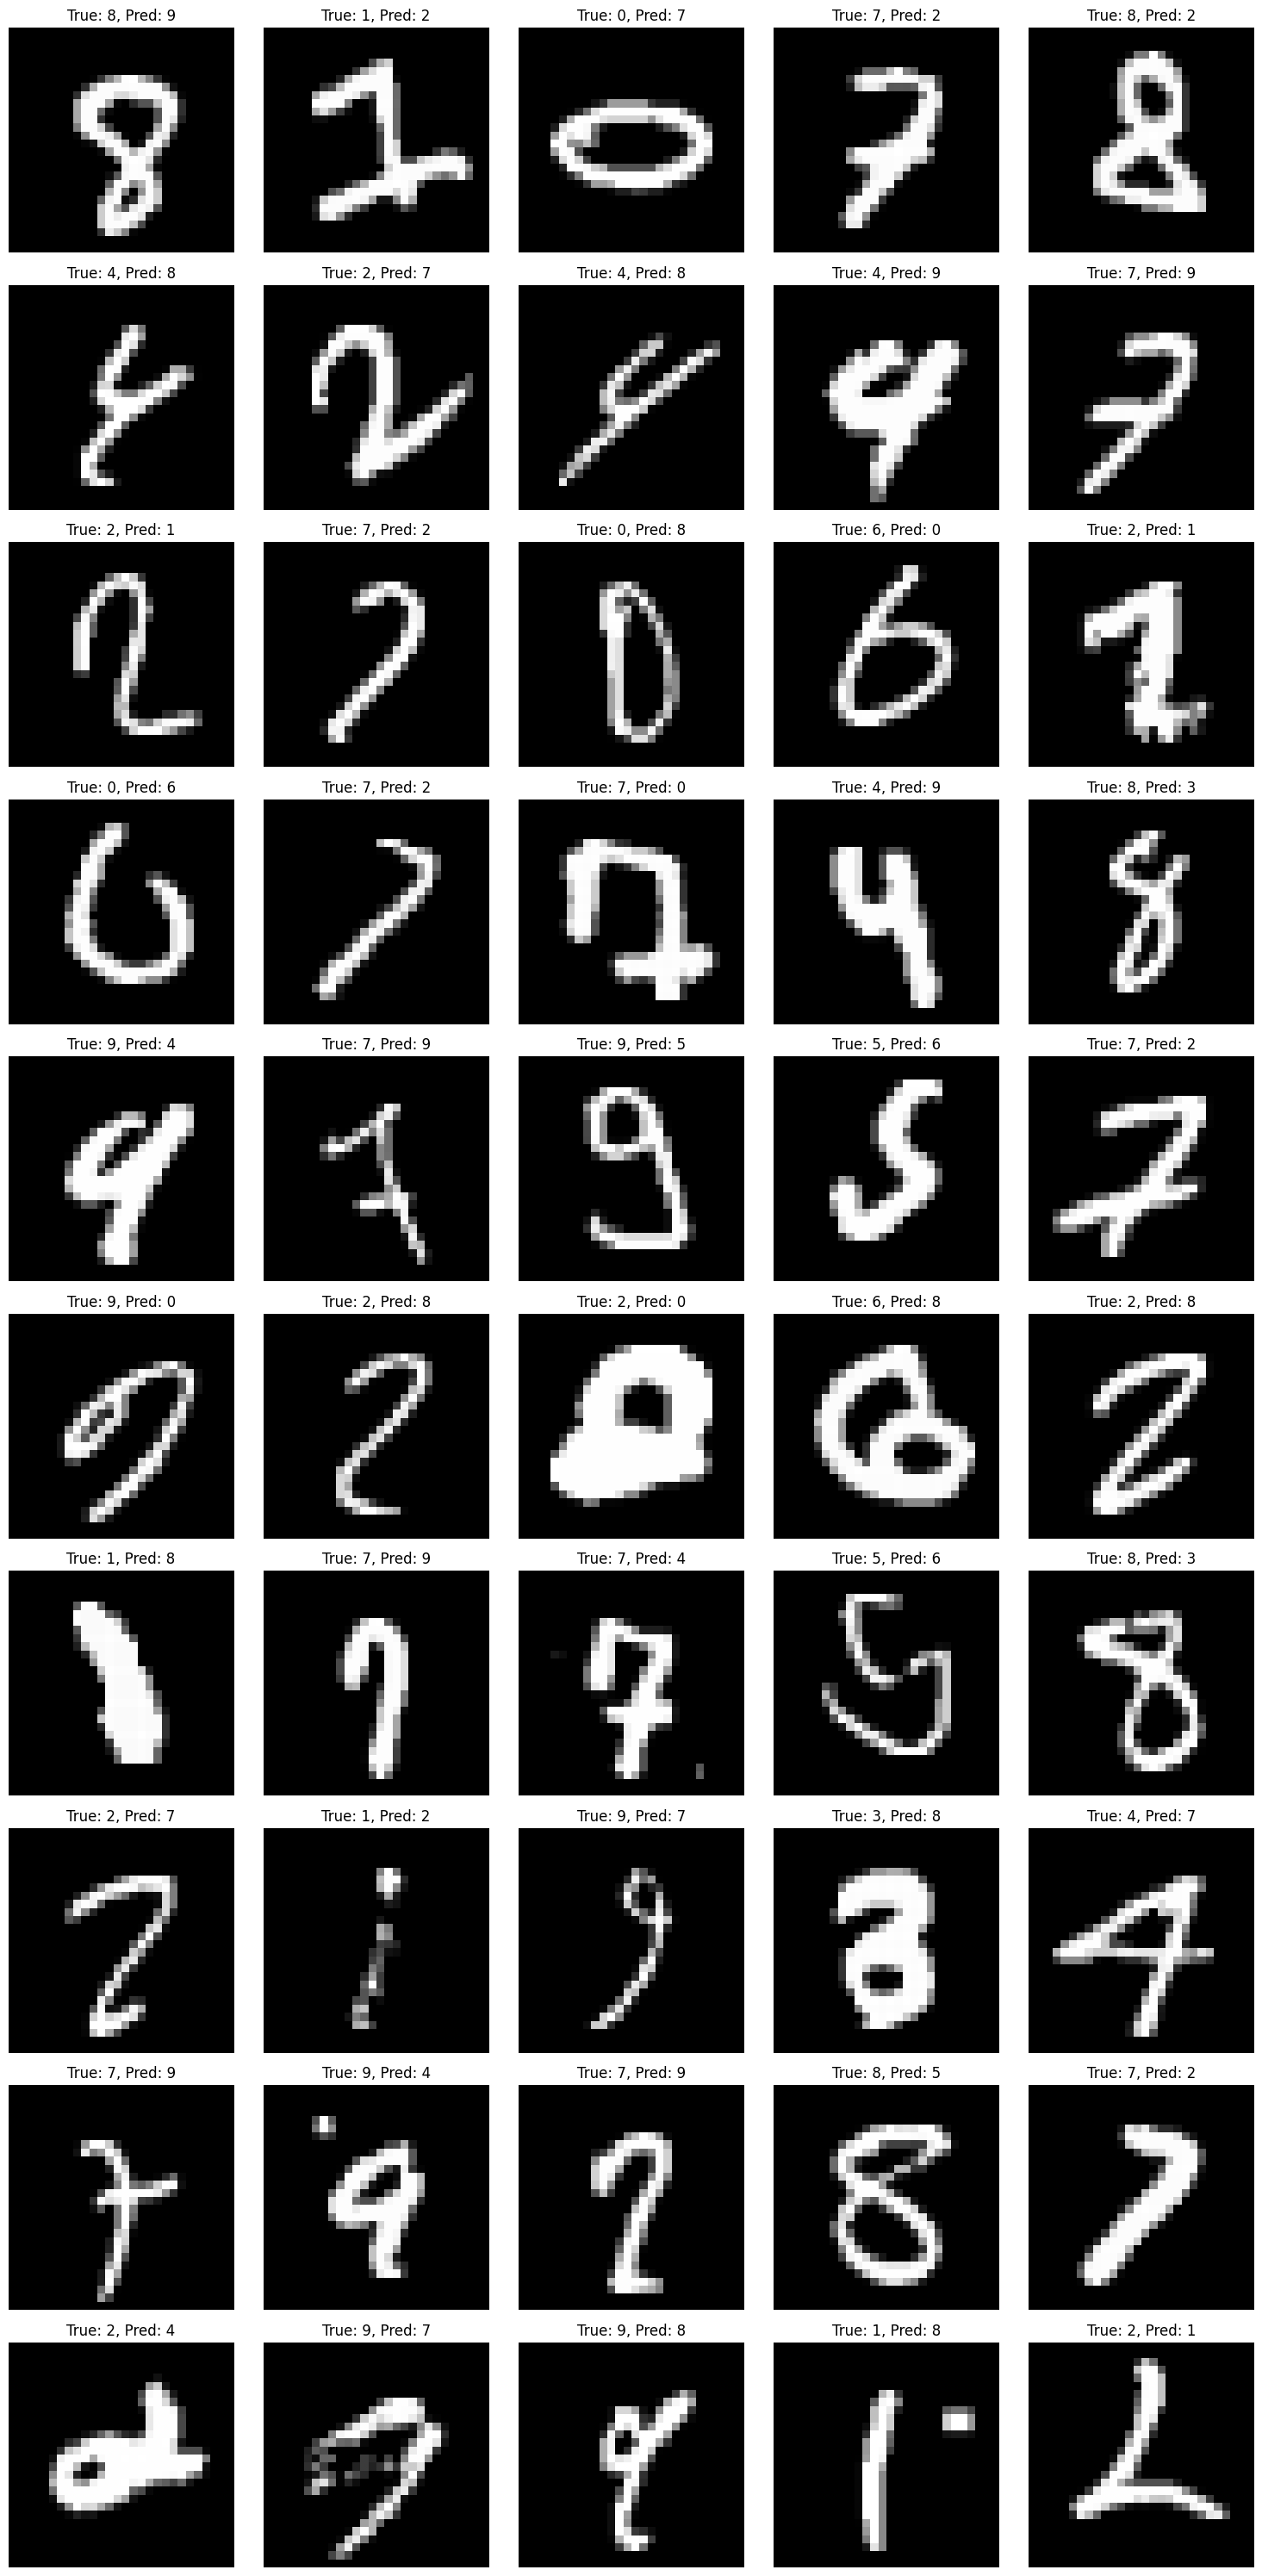

In [113]:
# display around 50 mismatched images

if mismatches:
    num_images = len(mismatches)
    cols = 5  
    rows = (num_images + cols - 1) // cols  
    plt.figure(figsize=(15, rows * 3))  # Set the figure size, adjusting height based on rows

    for i, (image, true_label, pred_label) in enumerate(mismatches, 1):
        plt.subplot(rows, cols, i)  # Set the subplot to be part of a grid
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
else:
    print("No misclassified images to display.")
